In [1]:
import torch
# print("是否支持 CUDA：", torch.cuda.is_available())  # 输出 True 表示可用
# print("GPU 设备数量：", torch.cuda.device_count())  # 输出 >=1 表示有可用 GPU
# print("当前 GPU 名称：", torch.cuda.get_device_name(0))  # 显示 GPU 型号（如 Tesla V100）
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ckpt_path = "/home/lurui/state/competition_support_set/competition_experiment9.11_1/first_run/checkpoints/last.ckpt"
# try:
#     ckpt = torch.load(ckpt_path,map_location=device,weights_only=False)
# except Exception as e:
#     print(f"加载失败，错误信息为{e}")
#     exit()
# print("="*50)
# print("ckpt顶层键（top-level keys）：")
# for top_key in ckpt.keys():
#     print(f"  - {top_key}")
# print("="*50)
# print("ckpt顶层键（top-level keys）：")
# for top_key in ckpt.keys():
#     print(f"  - {top_key}")
# print("\n" + "="*50)
# print("训练结果相关的关键信息：")
# # 遍历所有键值对，筛选关键词
# target_keywords = ["loss", "acc", "accuracy", "metric", "epoch", "lr", "learning_rate", "val_", "train_"]
# for top_key, value in ckpt.items():
#     # 情况1：顶层key直接是训练指标（如"train_loss": 0.123）
#     if any(kw in top_key.lower() for kw in target_keywords):
#         print(f"  {top_key}: {value}")  # 直接打印数值（若为张量则取.item()）
    
#     # 情况2：指标藏在子字典里（如"metrics": {"train_loss": 0.123, "val_acc": 0.95}）
#     try:
#         # 尝试判断是否为字典/状态字典，若有子key则递归检查
#         if isinstance(value, dict):
#             for sub_key, sub_val in value.items():
#                 if any(kw in sub_key.lower() for kw in target_keywords):
#                     # 若为张量（如PyTorch Tensor），转成数值；否则直接打印
#                     final_val = sub_val.item() if hasattr(sub_val, "item") else sub_val
#                     print(f"  {top_key}->{sub_key}: {final_val}")
#     except:
#         continue  # 非字典类型跳过，避免报错

数据列名（包含的训练指标）：
['batch_time_avg', 'batch_time_cv_percent', 'batch_time_max', 'batch_time_max_min_ratio', 'batch_time_min', 'batches_per_second', 'cell_sets_per_sec', 'epoch', 'flops_per_batch', 'mfu (%)', 'step', 'train_loss', 'val_loss']


/tmp/ipykernel_104245/3850028556.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


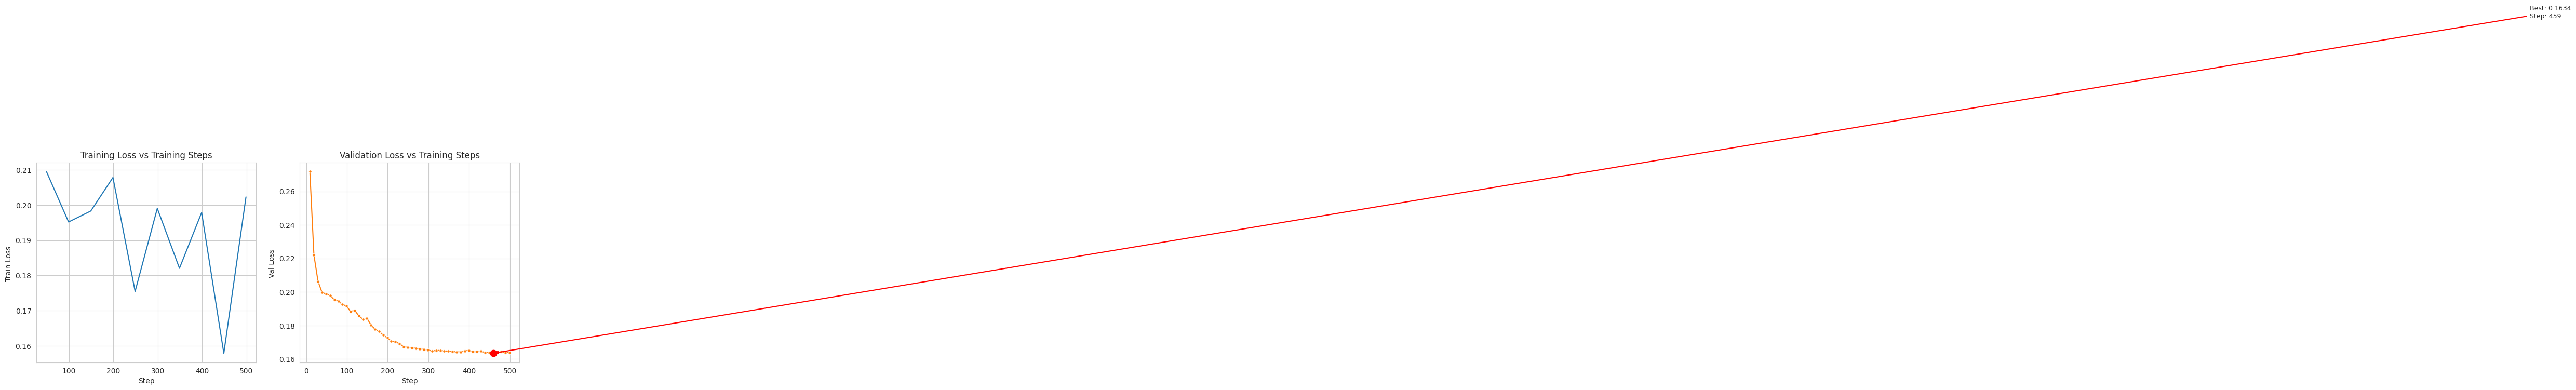

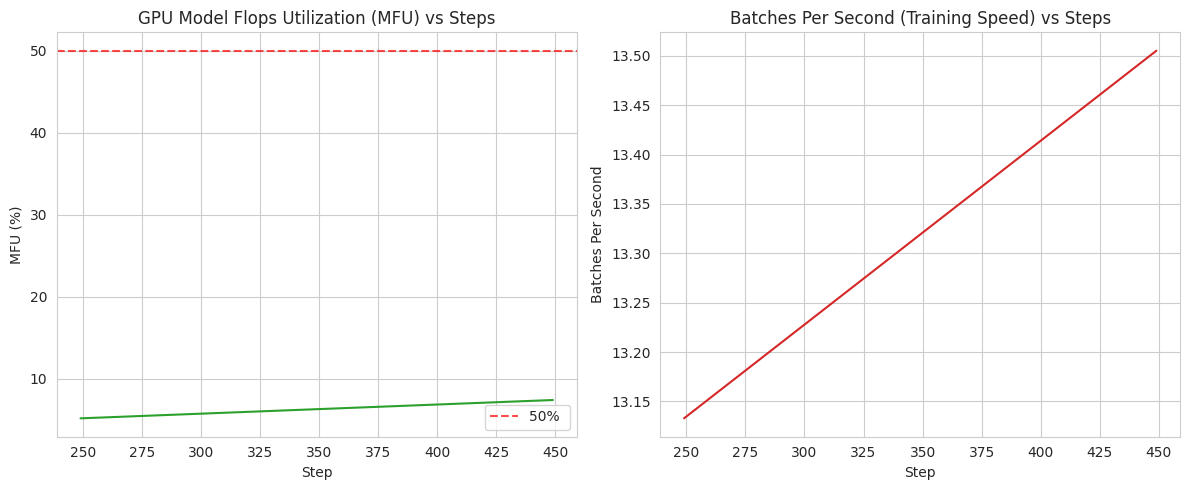

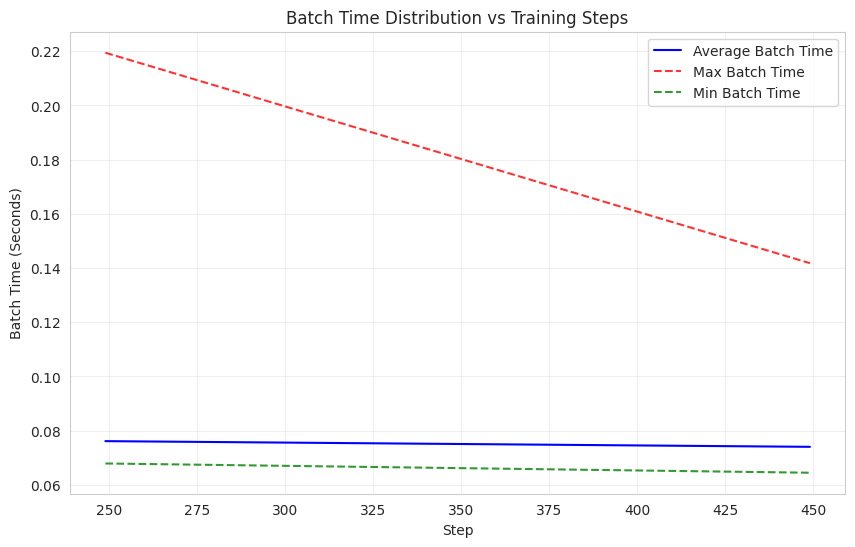

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

metrics = pd.read_csv("/home/lurui/state/tx_train_experiment/cellline_10.29.1/version_0/metrics.csv")

print("="*50)
print("数据列名（包含的训练指标）：")
print(metrics.columns.tolist())  # 输出所有列名，确认是否有 train_loss、val_loss 等

df = metrics.sort_values("step").reset_index(drop=True)
train_df = df.dropna(subset=["train_loss"])[["step", "train_loss"]]
val_df = df.dropna(subset=["val_loss"])[["step", "val_loss"]]

# 绘图
plt.figure(figsize=(12, 5))
sns.set_style("whitegrid")

# 子图1：训练损失曲线
plt.subplot(1, 2, 1)
sns.lineplot(x="step", y="train_loss", data=train_df, color="#1f77b4", linewidth=1.5)
plt.title("Training Loss vs Training Steps", fontsize=12)
plt.xlabel("Step", fontsize=10)
plt.ylabel("Train Loss ", fontsize=10)
plt.xticks(rotation=0)

# 子图2：验证损失曲线（标注最优值）
plt.subplot(1, 2, 2)
sns.lineplot(x="step", y="val_loss", data=val_df, color="#ff7f0e", linewidth=1.5, marker="o", markersize=4)
# 标注最优验证损失
best_val = val_df["val_loss"].min()
best_step = val_df[val_df["val_loss"] == best_val]["step"].iloc[0]
plt.scatter(best_step, best_val, color="red", s=80, zorder=5)
# plt.annotate(f"Best: {best_val:.4f}\nStep: {best_step}", 
#              xy=(best_step, best_val), 
#              xytext=(best_step+5000, best_val+0.2),
#              arrowprops=dict(arrowstyle="->", color="red", lw=1.5),
#              fontsize=9)
plt.title("Validation Loss vs Training Steps", fontsize=12)
plt.xlabel("Step", fontsize=10)
plt.ylabel("Val Loss ", fontsize=10)
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig("train_val_loss.png", dpi=300, bbox_inches="tight")
plt.show()

# 提取硬件相关指标（去除空值）
hardware_df = df.dropna(subset=["mfu (%)", "batches_per_second"])[["step", "mfu (%)", "batches_per_second"]]

plt.figure(figsize=(12, 5))

# 子图1：GPU 模型计算利用率（mfu）
plt.subplot(1, 2, 1)
sns.lineplot(x="step", y="mfu (%)", data=hardware_df, color="#2ca02c", linewidth=1.5)
plt.axhline(y=50, color="red", linestyle="--", alpha=0.7, label="50% ")  # 最低合理利用率
plt.title("GPU Model Flops Utilization (MFU) vs Steps", fontsize=12)
plt.xlabel("Step", fontsize=10)
plt.ylabel("MFU (%)", fontsize=10)
plt.legend()

# 子图2：每秒批次数（训练速度）
plt.subplot(1, 2, 2)
sns.lineplot(x="step", y="batches_per_second", data=hardware_df, color="#d62728", linewidth=1.5)
plt.title("Batches Per Second (Training Speed) vs Steps", fontsize=12)
plt.xlabel("Step", fontsize=10)
plt.ylabel("Batches Per Second", fontsize=10)

plt.tight_layout()
# plt.savefig("hardware_utilization.png", dpi=300, bbox_inches="tight")
plt.show()

# 提取批次时间相关指标
batch_time_df = df[["step", "batch_time_avg", "batch_time_max", "batch_time_min"]].dropna()

plt.figure(figsize=(10, 6))
sns.lineplot(x="step", y="batch_time_avg", data=batch_time_df, label="Average Batch Time", color="blue", linewidth=1.5)
sns.lineplot(x="step", y="batch_time_max", data=batch_time_df, label="Max Batch Time", color="red", linestyle="--", alpha=0.8)
sns.lineplot(x="step", y="batch_time_min", data=batch_time_df, label="Min Batch Time", color="green", linestyle="--", alpha=0.8)
plt.title("Batch Time Distribution vs Training Steps", fontsize=12)
plt.xlabel("Step", fontsize=10)
plt.ylabel("Batch Time (Seconds)", fontsize=10)
plt.legend()
plt.grid(alpha=0.3)
# plt.savefig("batch_time_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

若 mfu (%) 长期 < 30%：说明 GPU 算力浪费，需优化（如增大批次大小、减少数据加载耗时）；

若 batches_per_second 波动大：可能是数据加载不稳定（如多线程加载配置不合理）。